In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import random

## Meet the Data

In [2]:
from research_data import paths_pairs

!find Research-Data/* -type d -exec sh -c \
    'printf "%22s has %2d subjects\n" "{}" $(ls "{}"/*.genes.txt | wc -l)' \;

      Research-Data/CR has  8 subjects
    Research-Data/CRMs has 12 subjects
 Research-Data/Fasting has  4 subjects


In [3]:
from parse_genes import k_most_expressed_genes
from parse_desc import parse_desc_file
import json

# example
desc_path, genes_path = next(iter(paths_pairs))

print(f"""
{(desc_path, genes_path)}

{json.dumps(parse_desc_file(desc_path), indent=2, sort_keys=True)}

k=10 most expressed genes: """)
k_most_expressed_genes(genes_path, k=10)


('Research-Data/CR/1.desc.txt', 'Research-Data/CR/1.genes.txt')

{
  "Caloric Restriction Duration": "8 months",
  "Deficit Size": "60% of daily intake",
  "Name": "CR Group 1",
  "Organism": "mouse"
}

k=10 most expressed genes: 


,gene_symbol,logFC
0,cyp2b13,3.802507
1,fmo3,3.735119
2,anxa11,3.422603
3,gm43302,-3.062555
4,ccl21d,-3.044070
5,gm10273,3.017953
6,cidea,-2.436414
7,igkv3-2,-2.420975
8,gm4459,2.270074
9,mmp9,-2.265182


## Gene Expression Matrix

In [4]:
from parse_genes import all_genes_in_file


def full_gene_expression_table():
    # Load the Gene Expression Table of each Treatment
    all_data = []
    for desc_path, genes_path in paths_pairs:
        df = all_genes_in_file(genes_path)
        df['treatment_name'] = parse_desc_file(desc_path)['Name']
        all_data.append(df)

    # Combine all dataframes
    combined_data = pd.concat(all_data, ignore_index=True)
    result = combined_data.pivot_table(values='logFC', index='treatment_name', columns='gene_symbol', fill_value=0.0)
    result.index.name = None
    result.columns.name = ''

    return result
    
    
matrix = full_gene_expression_table()
print("Full Gene Expression Table has Shape", matrix.shape)

Full Gene Expression Table has Shape (24, 22377)


In [5]:
def extreme_gene_expression_table():
    """
    Extremely Up/Down Regulated Genes
    """
    matrix_extreme = matrix.copy()

    n = 3
    # Remove values within ± n * std_dev
    std_dev = matrix_extreme.stack().std()
    matrix_extreme[(matrix_extreme < 0) & (matrix_extreme >= -n * std_dev)] = 0
    matrix_extreme[(matrix_extreme > 0) & (matrix_extreme <= +n * std_dev)] = 0

    # Filter out columns with less than two non-zero values
    mask = (matrix_extreme != 0).sum(axis=0) >= 2
    return matrix_extreme.loc[:, mask]
    

matrix_extreme = extreme_gene_expression_table()

print("Extreme Gene Expression Table has Shape", matrix_extreme.shape)

matrix_extreme

Extreme Gene Expression Table has Shape (24, 2134)


,a2m,aadac,aadacp1,aars1,aatbc,abca1,abca13,abcc2,abcc3,abcd2,...,znf792,znf804a,znf85,znf883,zp1,zpld1,zranb1,zscan31,zwilch,zwint
2-deoxyglucose,0.000000,0.000000,0.000000,1.113989,0.000000,0.000000,1.427774,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"3,4-dimethoxychalcone",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.417500,1.188229,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 6,0.000000,-1.131475,-1.122125,0.000000,-1.232400,1.453241,0.000000,0.000000,0.000000,2.949497,...,0.000000,0.000000,0.000000,0.000000,0.893509,0.000000,0.933077,-1.009008,0.000000,0.000000
CR Group 7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.047875,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CR Group 8,0.000000,0.000000,0.000000,1.848228,0.000000,0.000000,0.000000,3.089548,0.000000,0.000000,...,-1.000318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.025079,-1.045234
CR Group 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.598217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Cosine Similarity

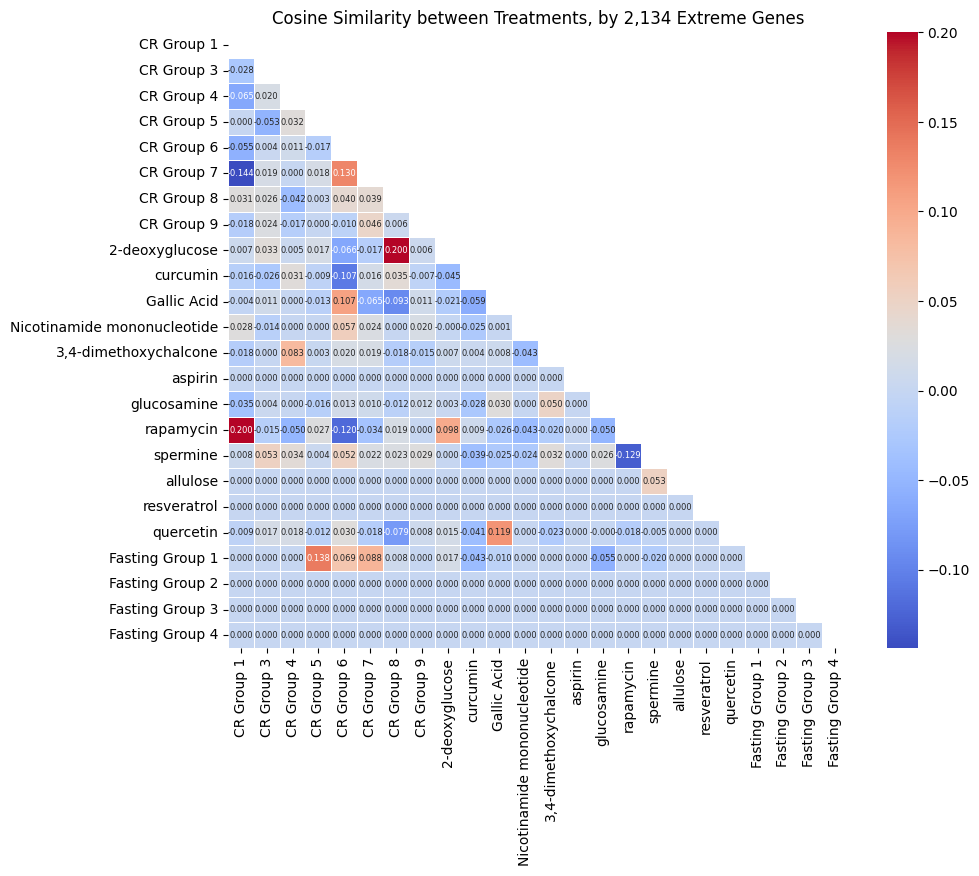

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from parse_desc import treatment_names


def plot_cosine_sim(gene_expressions, title):
    # Normalize each row
    norms = np.linalg.norm(gene_expressions, axis=1)
    norms = np.where(norms == 0, np.finfo(float).eps, norms)
    normalized_matrix = gene_expressions.div(norms, axis=0)

    # Compute cosine similarity
    cos_sim_matrix = cosine_similarity(normalized_matrix)

    # Create DataFrame, and preserve indices
    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=gene_expressions.index, columns=gene_expressions.index)

    # Re-order rows and columns based on 'node_names'
    cos_sim_df = cos_sim_df.reindex(index=treatment_names, columns=treatment_names)

    # Mask the lower triangle including diagonal
    mask = np.triu(np.ones_like(cos_sim_df, dtype=bool))

    # Set diagonal to NaN for visualization clarity
    np.fill_diagonal(cos_sim_df.values, np.nan)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, 
                linewidths=.5, mask=mask, annot_kws={'size': 6})
    plt.title(title)
    plt.show()
    
    
plot_cosine_sim(matrix_extreme, f'Cosine Similarity between Treatments, by {len(matrix_extreme.columns):,} Extreme Genes')

## Build Graph

In [7]:
from graph_functions import without_lone_nodes

NUM_GENES_PER_TREATMENT = 500

G = nx.Graph()

for treatment, genes in matrix.iterrows():
    G.add_node(treatment, category='treatment')
    
    for gene, _ in genes.abs().nlargest(NUM_GENES_PER_TREATMENT).items():
        
        if gene not in G:
            G.add_node(gene, category='gene')

        G.add_edge(treatment, gene)

G = HeterogeneousGraph = without_lone_nodes(G)

In [8]:
from collections import Counter

gene_nodes = [node for node, attrs in G.nodes(data=True) if attrs['category'] == "gene"]
degree_count = Counter(G.degree(gene) for gene in gene_nodes)

# Sort degrees and print in plain text
for degree in sorted(degree_count):
    print(f"{degree_count[degree]:>7,} Gene(s) have Degree {degree:,}")

  1,162 Gene(s) have Degree 2
    331 Gene(s) have Degree 3
     78 Gene(s) have Degree 4
    120 Gene(s) have Degree 5
    207 Gene(s) have Degree 6
     72 Gene(s) have Degree 7
      6 Gene(s) have Degree 8


In [9]:
print('Non-Gene Nodes a.k.a Treatment Nodes:')

pd.DataFrame(
    [
        { 'Degree': f"{len(list(G.neighbors(treatment))):,}" if treatment in G else 0 }
        for treatment in treatment_names
    ],
    index=treatment_names
)

Non-Gene Nodes a.k.a Treatment Nodes:


,Degree
CR Group 1,196
CR Group 3,180
CR Group 4,231
CR Group 5,324
CR Group 6,228
CR Group 7,237
CR Group 8,224
CR Group 9,205
2-deoxyglucose,279
curcumin,162


## Jaccard Coefficients

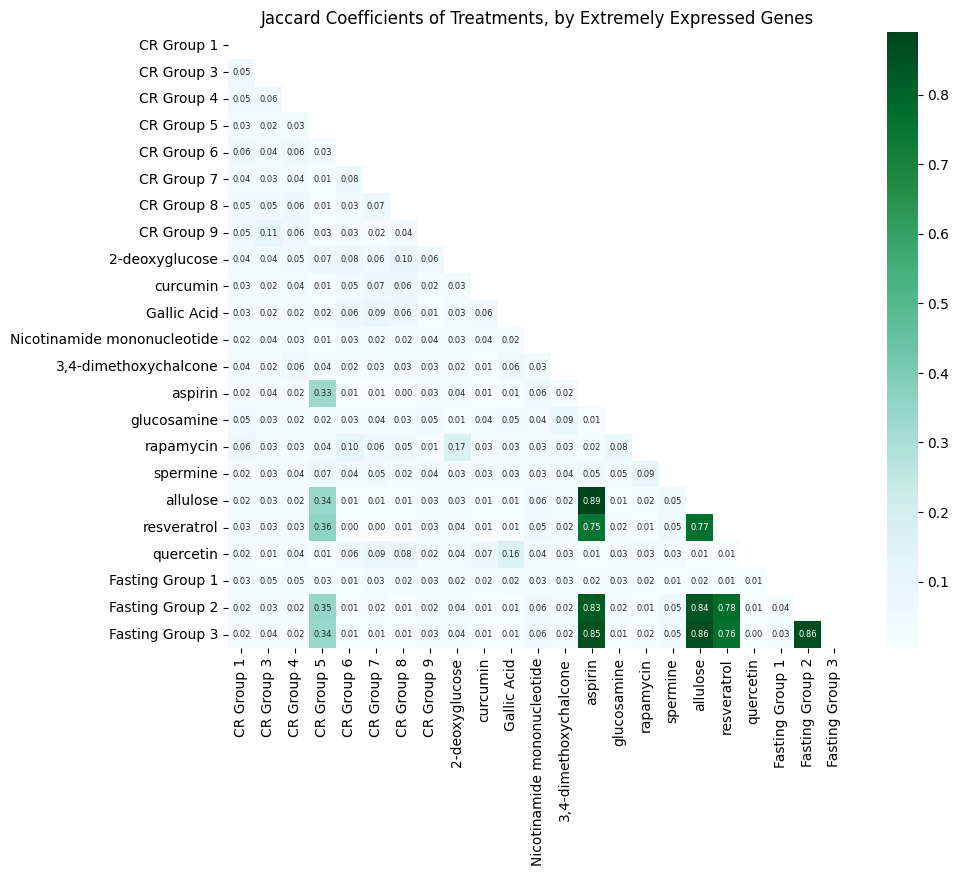

In [10]:
from itertools import combinations

def plot_jaccard_coefficients():
    node_names = [name for name in treatment_names if name in G]

    # Generate all pairs of non-gene nodes
    node_pairs = list(combinations(node_names, 2))

    jaccard_coeffs = list(nx.jaccard_coefficient(G, node_pairs))

    jaccard_matrix = np.zeros((len(node_names), len(node_names)))

    node_index = {node: idx for idx, node in enumerate(node_names)}

    # Populate the matrix
    for u, v, coeff in jaccard_coeffs:
        idx_u = node_index[u]
        idx_v = node_index[v]
        jaccard_matrix[idx_u][idx_v] = coeff
        jaccard_matrix[idx_v][idx_u] = coeff  # Ensure the matrix is symmetric

    jaccard_df = pd.DataFrame(jaccard_matrix, index=node_names, columns=node_names)

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(jaccard_df, dtype=bool))
    sns.heatmap(jaccard_df, cmap='BuGn', annot=True, fmt=".2f", mask=mask, annot_kws={'size': 6})
    plt.title('Jaccard Coefficients of Treatments, by Extremely Expressed Genes')
    plt.show()

plot_jaccard_coefficients()

## GNPS

In [11]:
"""
Gene-Gene Cosine Similarity
"""

def make_gene_gene_cos_sim_matrix(gene_expr_matrix):
    # Normalize each column
    norms = np.linalg.norm(gene_expr_matrix, axis=0)
    normalized_clean_matrix = gene_expr_matrix.div(norms, axis='columns')

    # Compute cosine similarity between columns
    cos_sim_clean_matrix = cosine_similarity(normalized_clean_matrix.T)  # Transpose to treat columns as vectors

    # Convert to DataFrame for better readability
    return pd.DataFrame(cos_sim_clean_matrix, index=gene_expr_matrix.columns, columns=gene_expr_matrix.columns)

gene_gene_cos_sim_matrix = make_gene_gene_cos_sim_matrix(matrix)

In [12]:
def GNPS(treatment, heterogeneous_graph):
    """
    Computes the Prioritization Score between the treatment and all genes.
    """
    related_genes = list(heterogeneous_graph.neighbors(treatment))
    related_columns = gene_gene_cos_sim_matrix.reindex(columns=related_genes, fill_value=0)
    result = related_columns.mean(axis=1)
    # squaring it because regulation values might be negative
    # multiplyig by some factor just so the values are easier to read
    return 128 * result ** 2


print(f"""
Example GNPS of a specific node (rapamycin) via G.
During training, GNPS will be calculated via G'. """)
GNPS("rapamycin", G)


Example GNPS of a specific node (rapamycin) via G.
During training, GNPS will be calculated via G'. 



0610009e02rik    0.077912
0610009l18rik    9.719959
0610010k14rik    0.010759
0610038b21rik    0.077912
0610040f04rik    0.077912
                   ...   
zyg11a           0.009343
zyg11b           0.140673
zyx              0.345488
zzef1            2.953405
zzz3             0.647835
Length: 22377, dtype: float64

## Build `G'` (reserve some edges for test-set)

In [13]:
G_prime = G.copy(as_view=False)

G_edges = list(G.edges())
test_edges = []

for _ in range(len(G_edges) // 5):
    popular_genes = [node for node, attrs in G_prime.nodes(data=True) 
                     if attrs['category'] == "gene" and G_prime.degree(node) >= 3]

    safe_edges = [
        (node, gene)
        for gene in popular_genes
        for node in G_prime.neighbors(gene) 
    ]
    
    if not safe_edges: break
    
    test_edge = random.choice(safe_edges)
    
    G_prime.remove_edge(*test_edge)
    test_edges.append(test_edge)


num_test_edges = len(test_edges)
print(f"{num_test_edges = :,}")

num_test_edges = 1,204


In [14]:
assert len(G_prime.edges()) == len(without_lone_nodes(G_prime).edges())

In [15]:
print(f"""
{len(G.edges()) = :,}    
{len(G_prime.edges()) = :,}

G' (train subgraph) has {100 * len(G_prime.edges()) / len(G.edges()):.1f}% of the edges. """)


len(G.edges()) = 6,023    
len(G_prime.edges()) = 4,819

G' (train subgraph) has 80.0% of the edges. 


## Make Data for the Neural Network

In [16]:
G_prime_treatment_nodes = [node for node, attrs in G_prime.nodes(data=True) if attrs['category'] != "gene"]

G_prime_treatment_nodes

['2-deoxyglucose',
 'rapamycin',
 'CR Group 7',
 'allulose',
 'resveratrol',
 'Fasting Group 3',
 'CR Group 5',
 'glucosamine',
 'spermine',
 'CR Group 6',
 'curcumin',
 'Fasting Group 1',
 'quercetin',
 'Fasting Group 2',
 '3,4-dimethoxychalcone',
 'CR Group 4',
 'Gallic Acid',
 'CR Group 1',
 'CR Group 9',
 'CR Group 8',
 'Nicotinamide mononucleotide',
 'CR Group 3',
 'aspirin']

In [17]:
"""
The positive examples are all the edges of G'.
"""

positive_examples = list(G_prime.edges())
np.random.shuffle(positive_examples)

# make sure gene name is always second
for i in range(len(positive_examples)):
    a, b = positive_examples[i]
    if b in G_prime_treatment_nodes:
        positive_examples[i] = (b, a)

print(f"{len(positive_examples) = } (num edges in G')\n")
print("positive_examples =", *positive_examples[:15], "...")

len(positive_examples) = 4819 (num edges in G')

positive_examples = ('CR Group 1', 'prdm9') ('curcumin', 'adora2a') ('CR Group 1', 'pcdhga12') ('2-deoxyglucose', 'ptpn18') ('allulose', 'apoe') ('CR Group 3', 'mxd1') ('CR Group 6', 'cygb') ('CR Group 1', 'kcnab2') ('allulose', '5031439g07rik') ('Fasting Group 2', '2610507i01rik') ('CR Group 9', 'wipi1') ('allulose', 'ac090204') ('CR Group 1', 'ighd') ('rapamycin', 'blnk') ('CR Group 4', 'gltp') ...


In [18]:
# To get negative examples, we'll start by scoring all links via GNPS.
links_gnps = []

for non_gene_node_name in G_prime_treatment_nodes:
    gene_scores = GNPS(non_gene_node_name, G_prime)
    # only consider genes that are in G'
    gene_scores = gene_scores[gene_scores.index.isin(G_prime.nodes())]
    for gene_idx, score in gene_scores.items():
        links_gnps.append((non_gene_node_name, gene_idx, score))

        
links_gnps.sort(key=lambda tup: abs(tup[-1]))

all_negative_examples = links_gnps[: len(positive_examples) + len(test_edges)]

np.random.shuffle(all_negative_examples)

all_negative_examples = [(non_gene_node_name, gene) for non_gene_node_name, gene, score in all_negative_examples]


negative_examples = all_negative_examples[: len(positive_examples)]

print(f"{len(negative_examples) = :,}\n")
print("negative_examples =", *negative_examples[:15], "...")

len(negative_examples) = 4,819

negative_examples = ('CR Group 8', 'c1orf162') ('quercetin', 'sult1a1') ('Fasting Group 3', '5730409e04rik') ('CR Group 6', '2210016l21rik') ('aspirin', 'celsr1') ('Fasting Group 2', 'ac132444') ('CR Group 8', '2310061i04rik') ('3,4-dimethoxychalcone', 'acat3') ('CR Group 6', 'cdc20') ('Fasting Group 2', 'zdhhc18') ('Gallic Acid', 'pacrg') ('CR Group 1', 'ac011239') ('quercetin', '2210016l21rik') ('CR Group 8', 'ptk2b') ('Fasting Group 3', 'man1b1') ...


## node2vec

In [19]:
from node2vec import Node2Vec


node2vec = Node2Vec(G_prime, dimensions=32, walk_length=5, num_walks=400, workers=8) \
               .fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/1999 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]


In [20]:
# Example embeddings of a specific node
example_node = G_prime_treatment_nodes[0]
example_node, node2vec.wv[example_node]

('2-deoxyglucose',
 array([ 0.40836892, -0.69931257,  0.14217122, -0.17301033,  0.7795927 ,
        -0.27922893,  0.60074174, -0.28090325,  0.02644298,  0.58545953,
        -0.22240305,  0.11333339, -0.3786634 , -0.37776497, -0.7007041 ,
         0.53132886, -0.4854992 ,  0.5904979 , -0.42801988,  0.16683365,
        -0.19987568,  0.2484736 ,  0.7838245 , -0.11305613,  0.21719375,
        -0.3925335 , -0.66874343,  1.1504291 ,  0.3774247 , -0.32844466,
        -0.95255345, -0.64744496], dtype=float32))

In [21]:
G_prime_GNPS = { treatment: GNPS(treatment, G_prime) for treatment in G_prime_treatment_nodes }

In [22]:
positive_embeddings = np.array([
    # concatenate (u + v) with GNPS number (or with 0 if the number isn't significant)
    [*(node2vec.wv[node] + node2vec.wv[gene]), G_prime_GNPS[node].get(gene, 0)]
    for (node, gene) in positive_examples
])

positive_embeddings.shape

(4819, 33)

In [23]:
negative_embeddings = np.array([
    # concatenate (u + v) with GNPS number (or with 0 if no GNPS)
    [*(node2vec.wv[node] + node2vec.wv[gene]), G_prime_GNPS[node].get(gene, 0)]
    for (node, gene) in negative_examples
])

negative_embeddings.shape

(4819, 33)

In [24]:
X_train = np.concatenate([positive_embeddings, negative_embeddings])
y_train = np.concatenate([np.ones(len(positive_embeddings)), np.zeros(len(negative_embeddings))])

print(f"""
    {X_train.shape = }
    {y_train.shape = }
    
    y_train = [1, 1, 1, ..., 1, 0, 0, 0, ..., 0]
""")


    X_train.shape = (9638, 33)
    y_train.shape = (9638,)
    
    y_train = [1, 1, 1, ..., 1, 0, 0, 0, ..., 0]



In [25]:
"""
Shuffle the train set
"""

indices = np.arange(y_train.size)
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

In [26]:
"""
Making the Test Set.
"""

positive_test_examples = test_edges

# make sure gene name is always second
for i in range(len(positive_test_examples)):
    a, b = positive_test_examples[i]
    if b in matrix.index:
        positive_test_examples[i] = (b, a)

negative_test_examples = all_negative_examples[
    len(negative_examples): len(negative_examples) + len(test_edges)
]


positive_test_embeddings = np.array([
    # concatenate (u + v) with GNPS number (or with 0 if the number isn't significant)
    [*(node2vec.wv[node] + node2vec.wv[gene]), G_prime_GNPS[node].get(gene, 0)]
    for (node, gene) in positive_test_examples
])

negative_test_embeddings = np.array([
    # concatenate (u + v) with GNPS number (or with 0 if the number isn't significant)
    [*(node2vec.wv[node] + node2vec.wv[gene]), G_prime_GNPS[node].get(gene, 0)]
    for (node, gene) in negative_test_examples
])


X_test = np.concatenate([positive_test_embeddings, negative_test_embeddings])
y_test = np.concatenate([np.ones(len(positive_test_embeddings)), np.zeros(len(negative_test_embeddings))])

print(f"""
    {X_test.shape = }
    {y_test.shape = }
""")


    X_test.shape = (2408, 33)
    y_test.shape = (2408,)



## The ML Model

In [27]:
from sklearn.tree import DecisionTreeClassifier
ml_model = DecisionTreeClassifier()

ml_model.fit(X_train, y_train)

DecisionTreeClassifier()

## Evaluate the model

In [28]:
train_accuracy = (ml_model.predict(X_train) == y_train).sum() / y_train.size

print(f"train_accuracy = {train_accuracy * 100:.2f}%")

train_accuracy = 96.98%


In [29]:
test_accuracy = (ml_model.predict(X_test) == y_test).sum() / y_test.size

print(f"test_accuracy = {test_accuracy * 100:.2f}%")

test_accuracy = 89.12%


In [30]:
mean = np.mean(X_train, axis=0)
stddev = np.std(X_train, axis=0)

X_rand = np.random.normal(loc=mean, scale=stddev, size=(1000, X_train.shape[1]))
y_rand = np.random.randint(2, size=(1000,))

rand_accuracy = (ml_model.predict(X_rand) == y_rand).sum() / y_rand.size

print(f"rand_accuracy = {rand_accuracy * 100:.2f}%")

rand_accuracy = 48.00%


In [31]:
"""
Interestingly, if we set the faked "gnps" to a very high number for y_rand that are 1,
The model is able to predict very well.
It shows that the model learned a positive correlation between the gnps value and y.
"""

X_rand = np.random.normal(loc=mean, scale=stddev, size=(1000, X_train.shape[1]))
y_rand = np.random.randint(2, size=(1000,))

for i in range(1000):
    X_rand[i][-1] = y_rand[i] * 1000000

rand_accuracy_with_extreme_gnps = (ml_model.predict(X_rand) == y_rand).sum() / y_rand.size

print(f"rand_accuracy_with_extreme_gnps = {rand_accuracy_with_extreme_gnps * 100:.2f}%")

rand_accuracy_with_extreme_gnps = 98.30%


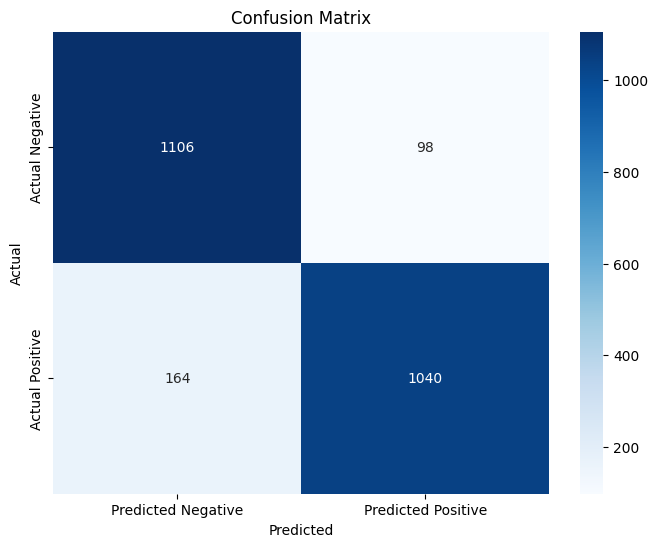

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = ml_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix using seaborn without ravel()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

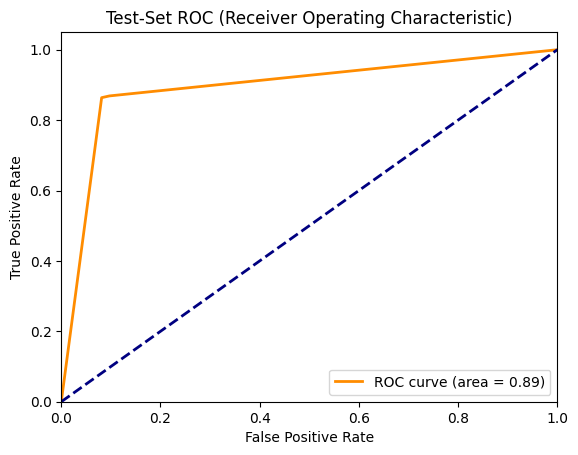

In [33]:
from sklearn.metrics import roc_curve, auc

y_scores = ml_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Finding the optimal index by maximizing Youden's Index
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test-Set ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()


## Novel Predictions

We'll use our model to predict missing links to `G`. We'll call it `G_extra`.

In [34]:
G_extra = G.copy(as_view=False)

In [35]:
G_GNPS = { treatment: GNPS(treatment, G) for treatment in treatment_names if treatment in G }

In [36]:
def embed_edge_via_G(node, gene):
    """ 
    concatenates (u + v) with GNPS number (or with 0 if unknown gene).
    this function uses G, not G_prime.
    """
    if gene in treatment_names:
        node, gene = gene, node
    sum_nodes_embeddings = node2vec.wv[node] + node2vec.wv[gene]
    gnps = G_GNPS[node].get(gene, 0)
    return np.array([*sum_nodes_embeddings, gnps])

In [37]:
gene_nodes = {node for node, data in G.nodes(data=True) if data['category'] == 'gene'}

for node_idx, gene_idx in zip(treatment_names, gene_nodes):
    if G.has_edge(node_idx, gene_idx): continue
    
    if node_idx not in G or gene_idx not in G: continue
    
    score = ml_model.predict([embed_edge_via_G(node_idx, gene_idx)])

    if score >= optimal_threshold:
        G_extra.add_edge(node_idx, gene_idx)

print(f"""
    {len(G_extra.edges()) = :,}
    {len(G.edges()) = :,}
    
    # Predicted Edges: {len(G_extra.edges()) - len(G.edges())}
""")


    len(G_extra.edges()) = 6,041
    len(G.edges()) = 6,023
    
    # Predicted Edges: 18



In [38]:
predicted_edges = list(set(G_extra.edges()) - set(G.edges()))

for i in range(len(predicted_edges)):
    node_idx, gene_idx = predicted_edges[i]
    if gene_idx in treatment_names:
        predicted_edges[i] = gene_idx, node_idx

predicted_edges

[('curcumin', 'dennd1c'),
 ('CR Group 5', 'rasgef1b'),
 ('CR Group 1', 'gpr55'),
 ('quercetin', 'abhd4'),
 ('Nicotinamide mononucleotide', 'itgb2'),
 ('glucosamine', 'snap23'),
 ('CR Group 4', 'dhx58'),
 ('Fasting Group 2', 'csf3r'),
 ('resveratrol', 'lrrn2'),
 ('CR Group 7', 'sgk2'),
 ('3,4-dimethoxychalcone', 'sulf2'),
 ('CR Group 9', 'pik3cg'),
 ('Fasting Group 1', 'rassf5'),
 ('CR Group 3', 'dock2'),
 ('Gallic Acid', '9530026p05rik'),
 ('CR Group 8', 'blnk'),
 ('2-deoxyglucose', 'st3gal3'),
 ('CR Group 6', 'tincr')]